# COVID CT Scan Image Classification

This notebook analyzes the [SARS-COV-2 Ct-Scan Dataset](https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset), a large dataset of CT scans for SARS-CoV-2 (COVID-19) identification. The dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. This notebook classifies the images using a convolutional neural network or CNN to predict weather a CT Scan image has COVID or non-COVID.

In [1]:
pip install wheel

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Preporcessing the data

The image height, witdh, and the batch size are specified. The dataset is split for training and validation for the model. The validation_split parameter specifies that 20% of the images will be used for validation, and the subset parameter specifies that the remaining 80% of the images will be used for validation. The seed parameter ensures that the images are split into the training and validation sets randomly. The batch_size parameter specifies that the images will be loaded in batches of 64.

In [5]:
data_dir = r"C:\Users\purna\Downloads\New folder (2)\corona train"
img_height, img_width = 224, 224
batch_size = 64

In [6]:
img_height, img_width = 224, 224
batch_size = 64
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2491 files belonging to 2 classes.
Using 1993 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2491 files belonging to 2 classes.
Using 498 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'non-COVID']


## Visualize the data



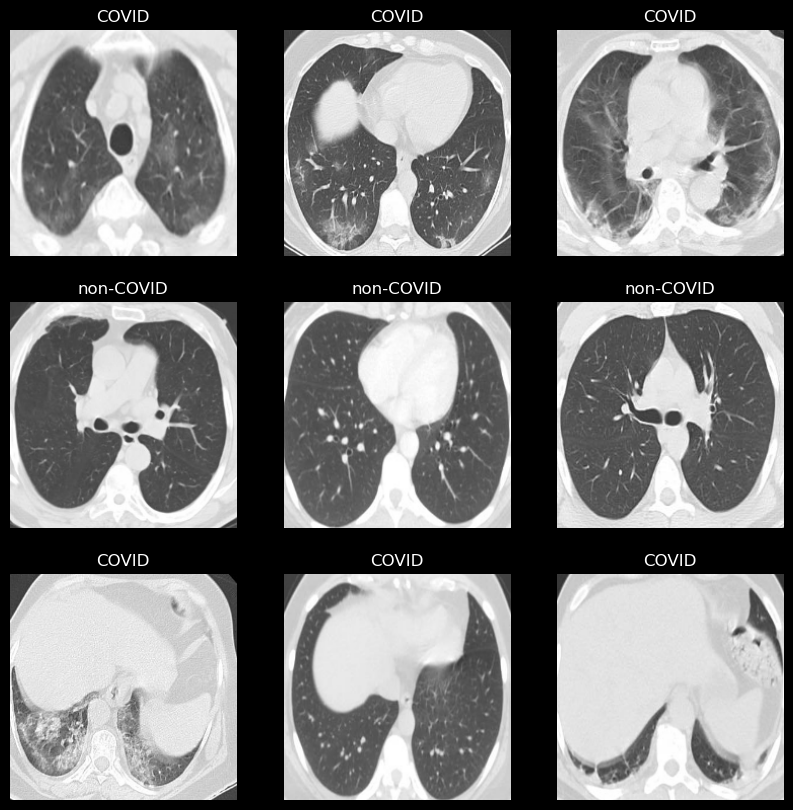

In [9]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

The autotune caches the training and validation datasets in memory and prefetches the next batch of data with a buffer size.
This helps to improve performance by reducing the amount of time that the model has to wait for data.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [11]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.26666668 1.0


## Create the model

The model contains four convolutional layers, each followed by a max pooling layer. The model uses a series of convolutional layers to extract features from the images, and then uses a dense layer to classify the images. The last layer is a dense layer with one neuron, which outputs a probability between 0 and 1 indicating whether the CT scan is COVID or non-COVID.

In [12]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2), 
   layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'), 
    layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        1

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the model

The model is trained for 10 epochs the early stopping callback that will stop training if the validation loss does not improve for 3 epochs. The early stopping callback helps to prevent the model from overfitting to the training data.

In [14]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  callbacks=[callback],
  epochs = 10
)

Epoch 1/10
32/32 [==============================] - 36s 987ms/step - loss: 1.4357 - accuracy: 0.5911 - val_loss: 0.5812 - val_accuracy: 0.7229
Epoch 2/10
32/32 [==============================] - 29s 915ms/step - loss: 0.5314 - accuracy: 0.7406 - val_loss: 0.4816 - val_accuracy: 0.7610
Epoch 3/10
32/32 [==============================] - 30s 947ms/step - loss: 0.4057 - accuracy: 0.8224 - val_loss: 0.3955 - val_accuracy: 0.8213
Epoch 4/10
32/32 [==============================] - 29s 922ms/step - loss: 0.2960 - accuracy: 0.8766 - val_loss: 0.4095 - val_accuracy: 0.8112
Epoch 5/10
32/32 [==============================] - 29s 906ms/step - loss: 0.2486 - accuracy: 0.9002 - val_loss: 0.3360 - val_accuracy: 0.8373
Epoch 6/10
32/32 [==============================] - 30s 941ms/step - loss: 0.2178 - accuracy: 0.9112 - val_loss: 0.3094 - val_accuracy: 0.8594
Epoch 7/10
32/32 [==============================] - 59s 2s/step - loss: 0.1810 - accuracy: 0.9242 - val_loss: 0.4660 - val_accuracy: 0.8293
Ep

## Visualize training results

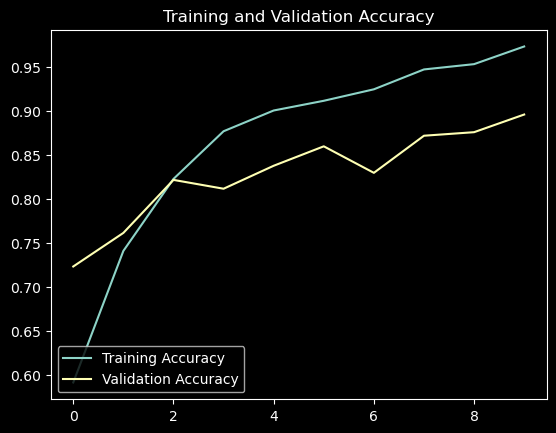

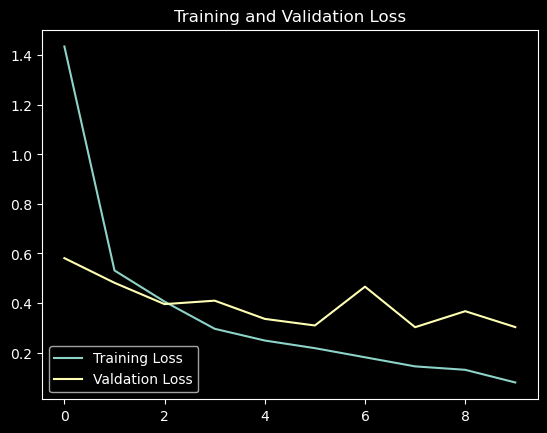

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower left')
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Valdation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

## Predictions

1/1 [==============================] - 1s 1s/step
This image is most likely COVID with 43.98 percent confidence.


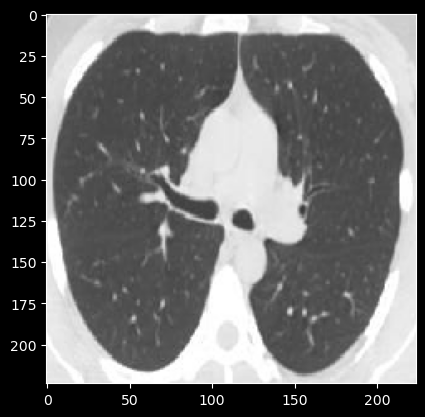

In [17]:
img_path = r"C:\Users\purna\Downloads\New folder (2)\corona train\non-COVID\Non-Covid (200).png"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = predictions[0]

print(
    "This image is most likely {} with {:.2f} percent confidence."
    .format(class_names[round(score[0])], 100 * np.max(score))
)

plt.imshow(img)

1/1 [==============================] - 0s 102ms/step
This image is most likely COVID with 0.09 percent confidence.


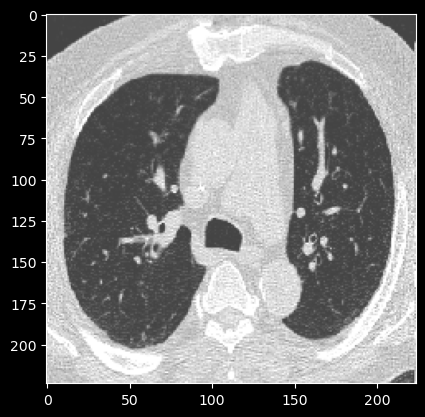

In [18]:
img_path = r"C:\Users\purna\Downloads\New folder (2)\corona train\COVID\Covid (143).png"
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = predictions[0]

print(
    "This image is most likely {} with {:.2f} percent confidence."
    .format(class_names[round(score[0])], 100 * np.max(score))
)

plt.imshow(img)

1/1 [==============================] - 0s 94ms/step
This image is most likely COVID with 0.09 percent confidence.


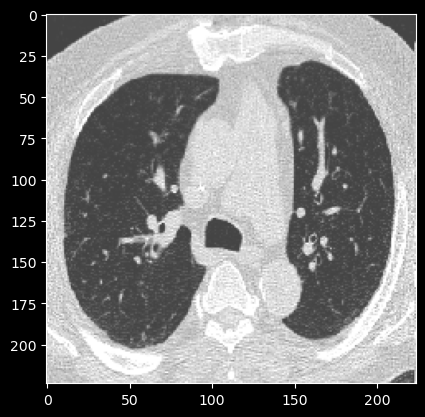

In [19]:
img_path = r"C:\Users\purna\Downloads\New folder (2)\corona train\COVID\Covid (143).png"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = predictions[0]

print(
    "This image is most likely {} with {:.2f} percent confidence."
    .format(class_names[round(score[0])], 100 * np.max(score))
)

plt.imshow(img)